# Formalizing the Problem
---
*Notation and definitions for the tuning curve and random search*

In [1]:
# imports

from matplotlib import pyplot as plt
import numpy as np

from experiments.simulation import Simulation, make_damped_linear_sin
from experiments.visualization import plot_distribution

# Configure environment.

generator = np.random.RandomState(0)


# Configure Matplotlib.

plt.style.use("experiments.default")

## A Model of Random Search

### Problem Setup

In *blackbox optimization*, we make a choice of inputs and then receive some score. Let $\pmb{x} = (x_1, \ldots, x_d)$ denote the vector of inputs, which takes values in a *search space*, $\pmb{x} \in \mathbb{X}$. For simplicity, we assume that the inputs are real numbers, $\mathbb{X} \subset \mathbb{R}^d$, and each has a corresponding bound, $a_j < x_j < b_j$; however, many of our results don't require this assumption. For any given choice, its value is a deterministic function of the inputs: $g(\pmb{x})$, $g: \mathbb{X} \to \mathbb{R}$.

In *random search*, we sample the inputs independently and identically from some distribution, $\mathcal{X}$, and keep the best. Thus, the inputs are random variables:

$$ \pmb{X}_i = [X_{i1}, \ldots, X_{id}] \sim \mathcal{X};\;\; 1 \leq i \leq n $$

And each random $\pmb{X}_i$ has a corresponding score, $Y_i$:

$$ Y_i = g(\pmb{X}_i) \in \mathbb{R};\;\; 1 \leq i \leq n $$

In general, $Y_i$ may not be a *deterministic* function of $\pmb{X}_i$, in which case $Y_i$ would have some distribution determined by $\pmb{X}_i$ instead.

All $Y_i$ are independent and identically distributed since all $\pmb{X}_i$ are. The distribution of $Y_i$ is called the *score distribution*, $\mathcal{Y}$. In addition, let $Y_{(i)}$ denote the $i^{th}$ order statistic, i.e. the $i^{th}$ smallest number from $Y_1, \ldots, Y_n$.

### The Tuning Process

We're interested in the *tuning process*, or the best score found after the first $k$ samples (as a function of $k$):

$$ T_k = \max_{i=1\ldots k} Y_i $$

The tuning process's distribution is described by its cumulative distribution function (CDF):

$$ F_k(y) = \mathbb{P}\left(T_k \leq y\right) $$

Or, equivalently by its probability density function (PDF):

$$ f_k(y) = \frac{d}{dy} F_k(y) $$

Which is in general the Radon-Nikodym derivative of the probability measure with respect to an appropriate base measure.

### Useful Facts

Let $F$ denote the CDF and $f$ the PDF for $\mathcal{Y}$. Then, we have a particularly simple formula for the CDF of the tuning process:

$$
\begin{align*}
  F_k(y) &= \mathbb{P}\left(T_k \leq y\right) \\
         &= \mathbb{P}\left(\max_{i=1\ldots k} Y_i \leq y\right) \\
         &= \mathbb{P}\left(Y_1 \leq y\land\ldots\land Y_k \leq y\right) \\
         &= \prod_{i=1}^k \mathbb{P}\left(Y_i \leq y\right) \\
         &= F(y)^k \\
\end{align*}
$$

Or, more elegantly:

$$ F_k(y) = F(y)^k $$

We obtain the PDF of $T_k$ by taking the derivative:

$$ f_k(y) = k F(y)^{k-1} f(y) $$

## An Example

Let's simulate an example to get some intuition.

### Visualizing Random Search

Here's what the process of random search looks like:

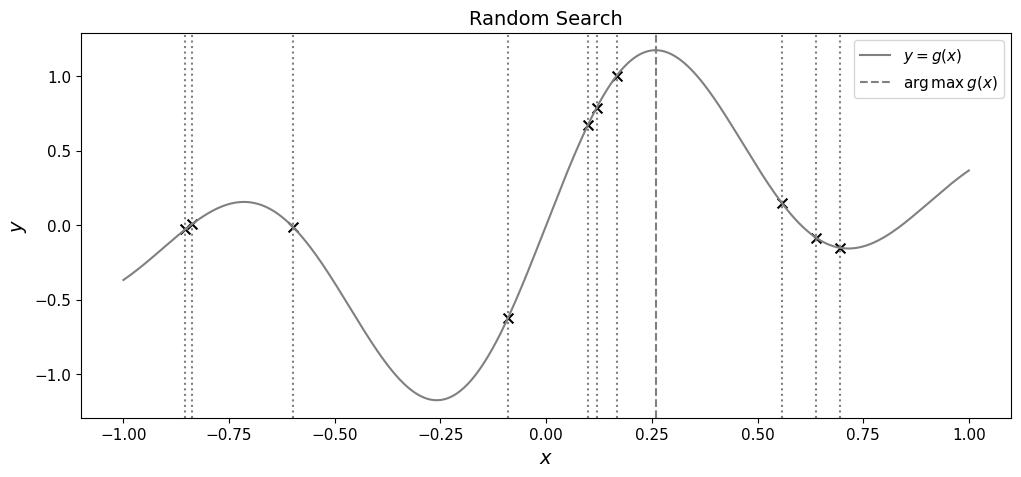

In [2]:
# Generate a multimodal function.
func = make_damped_linear_sin(weights=[1.], bias=0., scale=1.)

# Simulate random search.
s = Simulation.run(
    n_trials=10_000,
    n_samples=100,
    n_dims=1,
    func=func,
    bounds=[(-1, 1)],
    generator=generator,
)

# Visualize the simulation.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

n_samples = 10
n_grid = 1_024

grid = np.linspace(*s.bounds[0], num=n_grid).reshape(n_grid, 1)

y_argmax = grid[np.argmax(s.func(grid))]

xs = generator.uniform(*s.bounds[0], size=(n_samples, 1))
ys = s.func(xs)

ax.plot(
    grid,
    s.func(grid),
    linestyle="-",
    c="grey",
    label=r"$y = g(x)$",
)
ax.axvline(
    y_argmax,
    linestyle="--",
    c="grey",
    label=r"$\operatorname{arg\,max} g(x)$",
)
ax.scatter(xs, ys, marker="x", c="k", s=50)
for x in xs:
    ax.axvline(x, linestyle=":", c="grey")

ax.grid(visible=False)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_title("Random Search")

ax.legend()

plt.show()

Each "x" marks a point drawn from $\mathcal{X}$, where we evaluated $g(\pmb{X}_i)$. As more points are sampled, we find ones closer and closer to the maximum.

### Examining the CDF of the Max

With more samples, the distribution of the best score, $T_i$, becomes more regular and concentrates near the maximum.

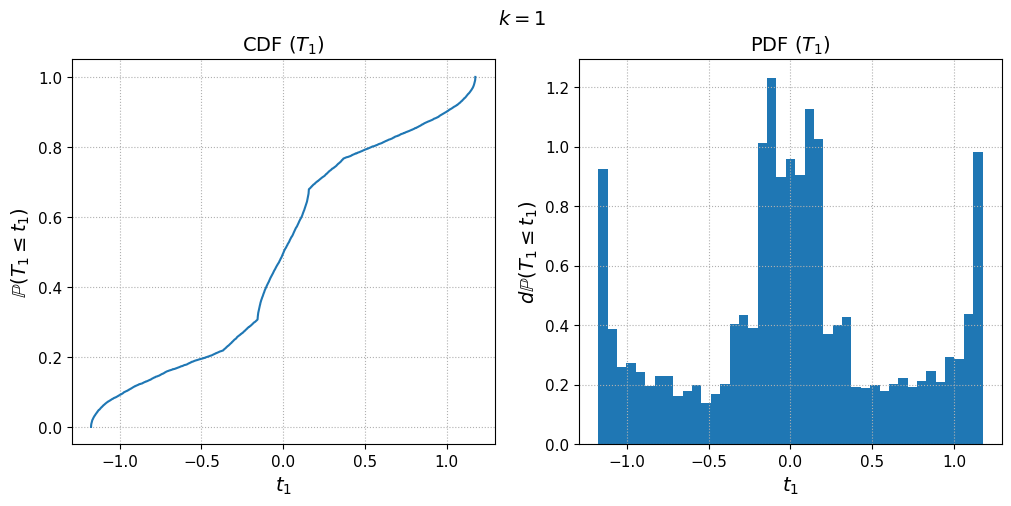

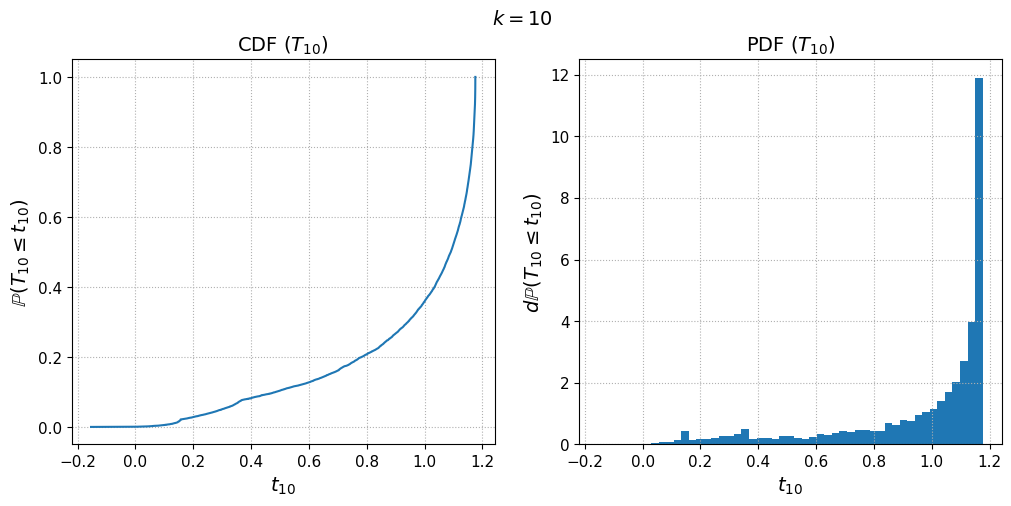

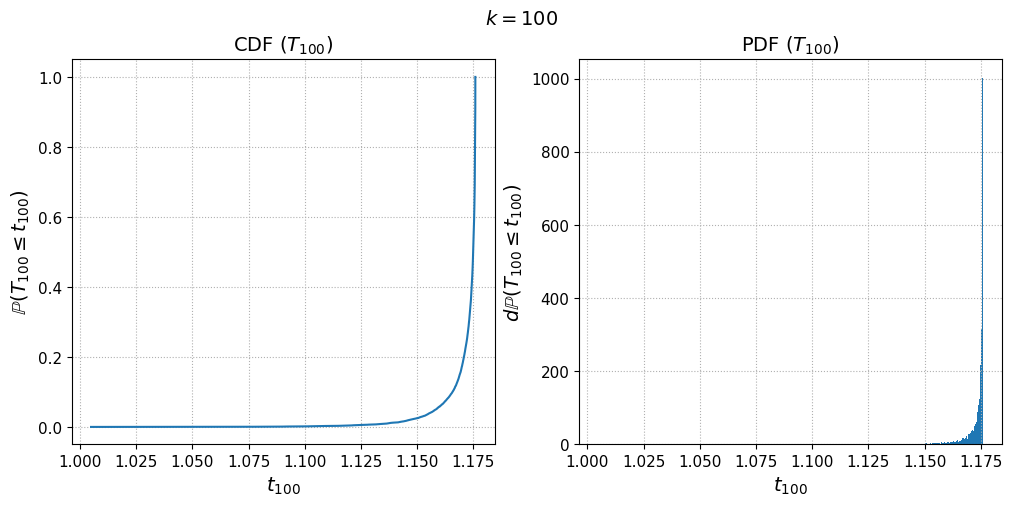

In [3]:
for k in [1, 10, 100]:
    fig, _ = plot_distribution(s.yss_cummax[:, k - 1], name=f"T_{{{k}}}")
    fig.suptitle(f"$k = {k}$")
    plt.show()

### Plotting the Tuning Curve

Instead of visualizing the distribution of each $T_k$ separately, we can see the trend as $k$ increases by plotting some summary statistic, like the mean or median, as a function of $k$:

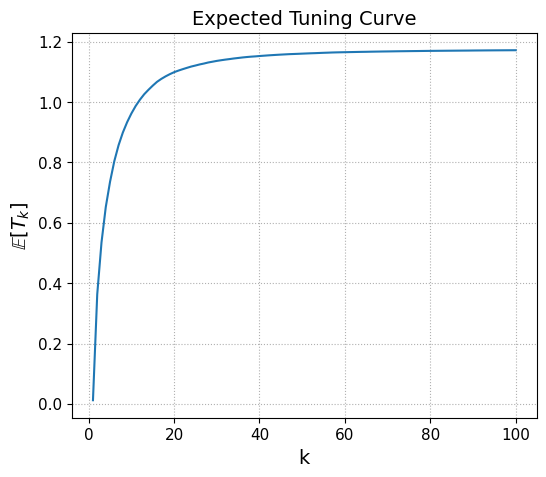

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.plot(s.ns, np.mean(s.yss_cummax, axis=0))
ax.set_xlabel("k")
ax.set_ylabel(r"$\mathbb{{E}}[T_k]$")
ax.set_title("Expected Tuning Curve")

plt.show()

This function is called the mean (or median) *tuning curve*.